## 라이브러리 & 함수

In [111]:
import time
import argparse
import numpy as np
import scipy.sparse as sp
import os
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from torch_geometric.data import Data
from dgl.nn.pytorch import GraphConv, GATConv
from scipy.stats import wasserstein_distance


ImportError: libssl.so.3: cannot open shared object file: No such file or directory

In [ ]:
def load_dataset(dataset,sens_attr,predict_attr, path="./dataset/pokec/", 
               label_number=1000, sens_number=500, test_idx=False, seed=1127):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    
    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)

    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    random.seed(seed)
    label_idx = np.where(labels>=0)[0]
    random.shuffle(label_idx)

    idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    if test_idx:
        idx_test = label_idx[label_number:]
        idx_val = idx_test
    else:
        idx_test = label_idx[int(0.75 * len(label_idx)):]

    sens = idx_features_labels[sens_attr].values

    sens_idx = set(np.where(sens >= 0)[0])
    idx_test = np.asarray(list(sens_idx & set(idx_test)))
    sens = torch.FloatTensor(sens)
    idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    random.seed(seed)
    random.shuffle(idx_sens_train)
    idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    # random.shuffle(sens_idx)

    return adj, features, labels, idx_train, idx_val, idx_test, sens,idx_sens_train

def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

def evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    if isinstance(model, (FairGNN, DistributionAwareFairGNN)) or hasattr(model, 'fairness_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)
        
    preds_eval = preds[idx_eval]
    sens_eval = data.sensitive_attr[idx_eval]
    
    g0 = preds_eval[sens_eval == 0]
    g1 = preds_eval[sens_eval == 1]
    
    if len(g0) == 0 or len(g1) == 0:
        fair_loss = None
    else:
        fair_loss = torch.abs(g0.mean() - g1.mean()).item()
        
    qr_loss = quantile_loss(data.y[idx_eval], preds_eval, tau).item()
    return qr_loss, fair_loss

def evaluate_metrics(model, data, idx_eval, tau=0.9):
    model.eval()

    if isinstance(model, (MYFairGNN, DAFGNN)):
        if isinstance(model, DAFGNN):
            preds, _ = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        else:
            preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)

    preds = preds[idx_eval].cpu()
    y_true = data.y[idx_eval].cpu()
    sensitive = data.sensitive_attr[idx_eval].cpu()

    error = y_true - preds
    qr_loss = torch.mean(torch.max(tau * error, (tau - 1) * error)).item()
    mae = torch.mean(torch.abs(error)).item()
    rmse = torch.sqrt(torch.mean(error ** 2)).item()
    r2 = 1 - torch.sum(error ** 2) / torch.sum((y_true - y_true.mean()) ** 2)

    group0 = preds[sensitive == 0]
    group1 = preds[sensitive == 1]
    fair_gap = torch.abs(group0.mean() - group1.mean()).item()

    results = {
        'QR Loss': qr_loss,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2.item(),
        'Fairness Gap': fair_gap
    }

    return results

def groupwise_evaluation(model, data, idx_eval, tau=0.9):
    model.eval()

    preds, _ = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)

    preds = preds[idx_eval]
    y_true = data.y[idx_eval]
    sensitive = data.sensitive_attr[idx_eval]

    # 전체 QR loss
    overall_qr = quantile_loss(y_true, preds, tau).item()

    # Group별 나누기
    preds_g0 = preds[sensitive == 0]
    preds_g1 = preds[sensitive == 1]
    y_true_g0 = y_true[sensitive == 0]
    y_true_g1 = y_true[sensitive == 1]

    # Group별 QR loss
    qr_loss_g0 = quantile_loss(y_true_g0, preds_g0, tau).item()
    qr_loss_g1 = quantile_loss(y_true_g1, preds_g1, tau).item()

    # Group별 예측 평균 (Fairness 측정용)
    mean_pred_g0 = preds_g0.mean().item()
    mean_pred_g1 = preds_g1.mean().item()
    fairness_gap = abs(mean_pred_g0 - mean_pred_g1)

    results = {
        'Overall QR Loss': overall_qr,
        'Group 0 QR Loss': qr_loss_g0,
        'Group 1 QR Loss': qr_loss_g1,
        'Fairness Gap (mean)': fairness_gap,
    }

    return results

def train_model(model_class, data, device, tau=0.9, lambda_fair=None,
                hidden_dim=64, n_epochs=500, lr=0.01, weight=5e-4):
    
    in_dim = data.x.size(1)
    if model_class.__name__ == 'DAFGNN':
        model = model_class(in_dim, hidden_dim, device, lambda_fair).to(device)
    elif model_class.__name__ == 'MYFairGNN':
        model = model_class(in_dim, hidden_dim, lambda_fair).to(device)
    elif model_class.__name__ == 'MYPlainGNN':
        model = model_class(in_dim, hidden_dim).to(device)
    elif model_class.__name__ == 'FairGNN_Q':
        model = model_class(in_dim, hidden_dim).to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight)

    data = data.to(device)
    data.sensitive_attr = data.sensitive_attr.to(device)
    
    print('-' * 100)
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        if isinstance(model, DAFGNN):
            preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
            loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        elif isinstance(model, MYFairGNN):
            preds = model(data.x, data.edge_index, data.sensitive_attr)
            loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
        elif isinstance(model, MYPlainGNN):
            preds = model(data.x, data.edge_index)
            loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
        elif isinstance(model, FairGNN_Q):
            model.optimize(g, x, labels, idx_train, sens, idx_sens_train)
            g, x, labels, idx_train, sens, idx_sens_train
            

        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 or epoch == 1:
            print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")
            
    return model

def train_one_epoch(model, data, optimizer, epoch, tau=0.9):
    model.train()
    optimizer.zero_grad()

    if isinstance(model, DAFGNN):
        preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
    elif isinstance(model, MYFairGNN) or hasattr(model, 'fairness_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
        loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
    else:
        preds = model(data.x, data.edge_index)
        loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)

    loss.backward()
    optimizer.step()
    return loss.item()

def run_experiment(model_class, data, device, tau=0.9, lambda_fair=None,
                   hidden_dim=64, n_epochs=500, lr=0.01, weight=5e-4):
    
    in_dim = data.x.size(1)
    if model_class.__name__ == 'DAFGNN':
        model = model_class(in_dim, hidden_dim, device, lambda_fair).to(device)
    elif model_class.__name__ == 'MYFairGNN':
        model = model_class(in_dim, hidden_dim, lambda_fair).to(device)
    else:
        model = model_class(in_dim, hidden_dim).to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight)

    best_val_qr = float('inf')
    best_model = None
    
    print('-' * 100)
    for epoch in range(1, n_epochs + 1):
        train_one_epoch(model, data, optimizer, epoch, tau=tau)
        val_qr, val_fair = evaluate(model, data, data.idx_val, tau=tau)
        
        if val_qr < best_val_qr:
            best_val_qr = val_qr
            best_model = model.state_dict()

        if epoch % 100 == 0 or epoch == n_epochs:
            print(f"[{model_class.__name__}] Epoch {epoch}: Val QR Loss={val_qr:.4f}, Fairness Gap={val_fair:.4f}")
            
    model.load_state_dict(best_model)
    test_qr, test_fair = evaluate(model, data, data.idx_test, tau=tau)
    return test_qr, test_fair

def multi_run_experiment(model_class, data, device, n_runs=5, tau=0.9, lambda_fair=None):
    qr_losses = []
    fair_gaps = []
    
    print('-' * 100)
    for run in range(n_runs):
        qr, fair = run_experiment(model_class, data, device, tau, lambda_fair)
        qr_losses.append(qr)
        fair_gaps.append(fair)
        
        print(f"Run {run+1}/{n_runs} completed: QR Loss={qr:.4f}, Fairness Gap={fair:.4f}")

    return np.array(qr_losses), np.array(fair_gaps)

def multiple_runs_with_full_metrics(model_class, data, device, 
                                    n_runs=5, hidden_dim=64, n_epochs=500, tau=0.9, lambda_fair=None):
    
    all_metrics = []
    
    print('-' * 100)
    for run in range(n_runs):
        print(f"\n [{model_class.__name__}] --- Run {run+1}/{n_runs} ---")
        model = train_model(model_class, data, device, tau, lambda_fair, hidden_dim, n_epochs)

        metrics = evaluate_metrics(model, data, data.idx_test, tau)
        all_metrics.append(metrics)
        
    metrics_mean = {k: np.mean([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}
    metrics_std = {k: np.std([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}

    results = {}
    for k in metrics_mean:
        results[f"{k} Mean"] = metrics_mean[k]
        results[f"{k} Std"] = metrics_std[k]

    return results, all_metrics


In [6]:
# Ablation 실험
def ablation_train(model_class, data, device, 
                   hidden_dim=64, n_epochs=500, tau=0.9, lambda_fair=1.0, gamma=1.0, alpha=1.0, lr=0.01,
                   use_projection=True, use_fairness=True):
    
    model = model_class(data.x.size(1), hidden_dim, device, lambda_fair=lambda_fair, 
                        gamma=gamma, alpha=alpha, use_projection=use_projection, use_fairness=use_fairness
                        ).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0 or epoch == 1:
            print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")
    return model

def ablation_evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    preds = model(data.x, data.edge_index, data.sensitive_attr)
    preds = preds[idx_eval]
    y_true = data.y[idx_eval]
    sensitive = data.sensitive_attr[idx_eval]
    
    qr_loss = quantile_loss(y_true, preds, tau).item()
    g0 = preds[sensitive == 0]
    g1 = preds[sensitive == 1]
    fair_gap = abs(g0.mean() - g1.mean()).item()
    return qr_loss, fair_gap

def run_ablation_experiments(data, device, n_runs=5):
    results = []
    
    settings = [
        ("Full", True, True),
        ("w/o Projection", False, True),
        ("w/o Fairness", True, False),
        ("w/o Both", False, False)
    ]

    for setting_name, use_proj, use_fair in settings:
        qr_losses = []
        fair_gaps = []

        for run in range(n_runs):
            print(f"\n[{setting_name}] Run {run+1}/{n_runs}")
            
            model = ablation_train(DistributionAwareFairGNN, data, device,
                                   use_projection=use_proj, use_fairness=use_fair)
            qr, fair = ablation_evaluate(model, data, data.idx_test)
            qr_losses.append(qr)
            fair_gaps.append(fair)

        results.append({
            "Setting": setting_name,
            "QR Loss Mean": np.mean(qr_losses),
            "QR Loss Std": np.std(qr_losses),
            "Fairness Gap Mean": np.mean(fair_gaps),
            "Fairness Gap Std": np.std(fair_gaps)
        })
    return pd.DataFrame(results)


## 모델

In [106]:
class MYPlainGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class MYFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, x, edge_index, sensitive):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(group0.mean() - group1.mean())

    def total_loss(self, preds, y_true, sensitive, tau=0.9):
        # 기본 quantile loss
        error = y_true - preds
        quantile_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))

        # 공정성 정규화
        fair_loss = self.fairness_loss(preds, sensitive)

        return quantile_loss + self.lambda_fair * fair_loss

In [ ]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid,nclass)

    def forward(self, g, x):
        x = self.body(g,x)
        x = self.fc(x)
        return x

class GCN_Body(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GCN_Body, self).__init__()

        self.gc1 = GraphConv(nfeat, nhid)
        self.gc2 = GraphConv(nhid, nhid)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, x):
        x = F.relu(self.gc1(g, x))
        x = self.dropout(x)
        x = self.gc2(g, x)
        return x    
    
class GAT_body(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT_body, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = F.elu
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
            
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_hidden, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))
        
    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)

        return logits

class GAT(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()

        self.body = GAT_body(num_layers, in_dim, num_hidden, heads, feat_drop, attn_drop, negative_slope, residual)
        self.fc = nn.Linear(num_hidden,num_classes)
    
    def forward(self, g, inputs):

        logits = self.body(g,inputs)
        logits = self.fc(logits)

        return logits

def get_model(model, nfeat, num_hidden=64, dropout=0.5, num_heads=1, num_layers=1, num_out_heads=1, attn_drop=0.0, negative_slope=0.2, residual=False):
    if model == "GCN":
        model = GCN_Body(nfeat, num_hidden, dropout)
    elif model == "GAT":
        heads = ([num_heads] * num_layers) + [num_out_heads]
        model = GAT_body(num_layers, nfeat, num_hidden, heads,
                         dropout, attn_drop, negative_slope, residual)
    else:
        raise ValueError("Model not implemented")
    return model

class FairGNN_Q(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, model='GCN', dropout=0.5, hidden = 128, lr=0.001, weight=1e-5, tau=0.9):
        super(FairGNN_Q, self).__init__()
        
        nfeat = in_dim
        nhid = hidden_dim
        self.estimator = GCN(nfeat, hidden, 1, dropout)
        self.GNN = get_model(model, nfeat)
        self.classifier = nn.Linear(nhid, 1)
        self.adv = nn.Linear(nhid, 1)

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight)

        self.tau = tau  # Quantile 설정
        self.G_loss = 0
        self.A_loss = 0

    def forward(self, g, x):
        s = self.estimator(g, x)
        z = self.GNN(g, x)
        y = self.classifier(z)
        return y, s

    def optimize(self, g, x, labels, idx_train, sens, idx_sens_train):
        self.train()

        ### update GNN and Classifier
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(g, x)
        h = self.GNN(g, x)
        y = self.classifier(h)

        s_g = self.adv(h)

        s_score = s.detach()
        s_score[idx_sens_train] = sens[idx_sens_train].unsqueeze(1).float()

        self.cls_loss = self.quantile_loss(labels[idx_train].unsqueeze(1).float(), y[idx_train])  # Quantile loss 사용
        self.adv_loss = F.mse_loss(s_g, s_score)  # adversary는 MSE

        # 공정성 페널티
        cov = torch.abs(torch.mean((s_score - torch.mean(s_score)) * (y - torch.mean(y))))

        self.G_loss = self.cls_loss + self.args.alpha * cov - self.args.beta * self.adv_loss

        self.G_loss.backward()
        self.optimizer_G.step()

        ### update Adversary
        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        self.A_loss = F.mse_loss(s_g, s_score)

        self.A_loss.backward()
        self.optimizer_A.step()

In [107]:
class DAFGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, device, lambda_fair=1.0,
                 gamma=1.0, alpha=1.0, use_projection=True, use_fairness=True):
        
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.lambda_fair = lambda_fair
        self.alpha = alpha
        self.gamma = gamma
        
        self.use_projection = use_projection
        self.use_fairness = use_fairness
        
        self.device = device
        
    def forward(self, x, edge_index, sensitive, return_hidden=False):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds
        
    def distribution_aware_fairness_loss(self, preds, sensitive, var_gap=False):
        g0 = preds[sensitive == 0]
        g1 = preds[sensitive == 1]

        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=preds.device)

        mean_gap = torch.abs(g0.mean() - g1.mean())
        gap = mean_gap
        if var_gap:
            var_gap = torch.abs(g0.var(unbiased=False) - g1.var(unbiased=False))
            gap = mean_gap + self.alpha * var_gap
        return gap

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        bias = torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)
        return bias

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.lambda_fair * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        device = next(self.parameters()).device  # 모델 파라미터의 디바이스 확인
        return max_lambda * (1 - torch.exp(-beta * torch.tensor(epoch, dtype=torch.float32, device=device)))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        loss_qr = quantile_loss(y_true, preds, tau)
        
        # Projection
        if self.use_projection:
            bias_score = self.compute_bias_score(hidden, sensitive)
            hidden = self.adaptive_projection(hidden, bias_score)
        
        # Fairness
        if self.use_fairness:
            fair_loss = self.distribution_aware_fairness_loss(preds, sensitive)  
        else:
            fair_loss =  torch.tensor(0.0, device=preds.device)

        lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.lambda_fair)

        return loss_qr + lambda_fair * fair_loss

## 데이터셋

In [11]:
# region_job.csv: Pokec_z
# region_job2.csv: Pokec_n
# nba.csv: NBA

# completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
pokec_predict_attr = 'completion_percentage'
pokec_sens_attr = 'region' # gender
pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path = 500, 200, False, "./dataset/pokec"

# PIE (Player Impact Estimate): 통합 퍼포먼스 지표, 퍼포먼스에 대한 차별 여부 확인 가능
# MPG (Minutes Per Game): 출전 시간 → 팀의 코치 결정, 제도적 편향 가능성
nba_predict_attr = 'PIE'
nba_sens_attr = 'country'  # AGE, palyer_height, player_weight
nba_label_number, nba_sens_number, nba_test_idx, nba_path = 100, 50, True, "./dataset/NBA"

In [43]:
# # 데이터 셋 확인
# # df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job.csv')
# df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job_2.csv')
# # df = pd.read_csv('/home/sypark/CIKM/dataset/NBA/nba.csv')
# # print(df.columns)
# print(df.describe())

In [ ]:
# # 값 분포 확인
# col = pokec_predict_attr
# print(df[col].describe())
# # print(df[col].value_counts())

# plt.figure(figsize=(6, 3))
# plt.hist(df[col], bins=30, edgecolor='black')
# plt.title(f'Distribution of {col}')
# plt.xlabel(f'{col}')
# plt.ylabel('Count')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [12]:
# 데이터셋 로드
# dataset = 'pokec_z'
# dataset = 'pokec_n'
dataset = 'nba'

if dataset != 'nba':
    if dataset == 'pokec_z':
        dataset = 'region_job'
    else:
        dataset = 'region_job_2'
    predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path
else:
    dataset = 'nba'
    predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path

adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset(dataset,
                                                                                         sens_attr,
                                                                                         predict_attr,
                                                                                         path,
                                                                                         label_number,
                                                                                         sens_number,
                                                                                         test_idx,
                                                                                         seed=1127)

# PyG
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens)
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test

Loading nba dataset from ./dataset/NBA


## 실험

In [ ]:
# 실험 설정
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model_class = DAFGNN

device = 'cpu'
tau = 0.9
lambda_fair = 1.0
hidden_dim = 64
n_epochs = 500
n_runs = 5
lr = 0.01
weight = 5e-4

data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)

# training
model_tr = train_model(model_class, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)

----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 8.6269
[Epoch 100] Loss: 1.1330
[Epoch 200] Loss: 0.8880
[Epoch 300] Loss: 0.8541
[Epoch 400] Loss: 0.9351
[Epoch 500] Loss: 0.8374


### 단일 실험

In [38]:
# results
idx_eval = idx_test  # idx_train/idx_val

# qr_loss, fair_loss = evaluate(model_tr, data, idx_eval, tau)
# print('-' * 100)
# print('QR Loss:', np.round(qr_loss, 4), ', Fair Loss:', np.round(fair_loss, 4))

qr_loss, mae, rmse, r2, fair_loss = evaluate_metrics(model_tr, data, idx_eval, tau).values()
print('-' * 100)
print('QR Loss:', np.round(qr_loss, 4), ', Fair Loss:', np.round(fair_loss, 4))
print('MAE:', np.round(mae, 4), ', RMSE:', np.round(rmse, 4), ', R2:', np.round(r2, 4))

qr_loss, g0_qr_loss, g1_qr_loss, fair_loss = groupwise_evaluation(model_tr, data, idx_eval, tau).values()
print('-' * 100)
print('Group 0 QR Loss:', np.round(g0_qr_loss, 4), ', Group 1 QR Loss:', np.round(g1_qr_loss, 4))

----------------------------------------------------------------------------------------------------
QR Loss: 0.6425 , Fair Loss: 0.1426
MAE: 5.1668 , RMSE: 6.0334 , R2: -2.2198
----------------------------------------------------------------------------------------------------
Group 0 QR Loss: 0.6062 , Group 1 QR Loss: 0.7392


### 비교 실험

In [ ]:
# 간단 비교 실험
results = []

# Plain GNN
plain_qr, plain_fair = run_experiment(MYPlainGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
results.append({'Model': 'PlainGNN', 'QR Loss': plain_qr, 'Fairness Gap': plain_fair,})

# Fair GNN
fair_qr, fair_fair = run_experiment(MYFairGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
results.append({'Model': 'FairGNN', 'QR Loss': fair_qr, 'Fairness Gap': fair_fair,})

# DAFGNN-aware FairGNN
dist_qr, dist_fair = run_experiment(DAFGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
results.append({'Model': 'Our', 'QR Loss': dist_qr, 'Fairness Gap': dist_fair,})

----------------------------------------------------------------------------------------------------
[PlainGNN] Epoch 100: Val QR Loss=0.7093, Fairness Gap=0.9006
[PlainGNN] Epoch 200: Val QR Loss=0.6597, Fairness Gap=0.9074
[PlainGNN] Epoch 300: Val QR Loss=0.6700, Fairness Gap=0.8357
[PlainGNN] Epoch 400: Val QR Loss=0.6495, Fairness Gap=0.8148
[PlainGNN] Epoch 500: Val QR Loss=0.6451, Fairness Gap=0.8201
----------------------------------------------------------------------------------------------------
[FairGNN] Epoch 100: Val QR Loss=0.8102, Fairness Gap=0.4626
[FairGNN] Epoch 200: Val QR Loss=0.7803, Fairness Gap=0.2822
[FairGNN] Epoch 300: Val QR Loss=0.7094, Fairness Gap=0.1979
[FairGNN] Epoch 400: Val QR Loss=0.7350, Fairness Gap=0.0274
[FairGNN] Epoch 500: Val QR Loss=0.6497, Fairness Gap=0.1571
----------------------------------------------------------------------------------------------------
[DistributionAwareFairGNN] Epoch 100: Val QR Loss=0.7146, Fairness Gap=0.2262
[Dis

In [45]:
# 비교 실험 결과
pd.DataFrame(results).round(4)

,Model,QR Loss,Fairness Gap
0,PlainGNN,0.6451,0.8201
1,FairGNN,0.6497,0.1571
2,Our,0.6393,0.1121


In [ ]:
all_results = []

# 1. PlainGNN
plain_results, plain_all_metrics = multiple_runs_with_full_metrics(MYPlainGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair)
plain_results['Model'] = 'PlainGNN'
all_results.append(plain_results)

# 2. FairGNN
fair_results, fair_all_metrics = multiple_runs_with_full_metrics(MYFairGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair)
fair_results['Model'] = 'FairGNN'
all_results.append(fair_results)

# 3. DAFGNN
dist_results, dist_all_metrics = multiple_runs_with_full_metrics(DAFGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair)
dist_results['Model'] = 'Ours'
all_results.append(dist_results)

----------------------------------------------------------------------------------------------------

 [PlainGNN] --- Run 1/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 0.8686
[Epoch 100] Loss: 0.8231
[Epoch 200] Loss: 0.8325
[Epoch 300] Loss: 0.7685
[Epoch 400] Loss: 0.7592
[Epoch 500] Loss: 0.7999

 [PlainGNN] --- Run 2/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 5.4083
[Epoch 100] Loss: 0.8253
[Epoch 200] Loss: 0.8032
[Epoch 300] Loss: 0.9559
[Epoch 400] Loss: 0.7832
[Epoch 500] Loss: 0.7238

 [PlainGNN] --- Run 3/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 2.2246
[Epoch 100] Loss: 0.8269
[Epoch 200] Loss: 0.8055
[Epoch 300] Loss: 0.7564
[Epoch 400] Loss: 0.7436
[Epoch 500] Loss: 0.7854

 [PlainGNN] --- Run 4/5 ---
------------------------------------

In [54]:
# 비교 실험 결과
all_results = pd.DataFrame(all_results)
all_results.round(4)

,QR Loss Mean,QR Loss Std,MAE Mean,MAE Std,RMSE Mean,RMSE Std,R2 Mean,R2 Std,Fairness Gap Mean,Fairness Gap Std,Model
0,0.6252,0.0414,5.0021,0.8268,5.9316,0.8853,-2.1813,0.8839,0.7171,0.0799,PlainGNN
1,0.6539,0.0656,5.1879,1.1102,6.0130,1.1195,-2.3089,1.2941,0.1314,0.0954,FairGNN
2,0.6788,0.0371,5.6561,0.7951,6.5202,0.7742,-2.8133,0.8785,0.1303,0.0472,Ours


In [78]:
np.min(qr_means) - 0.1

0.5252215385437012

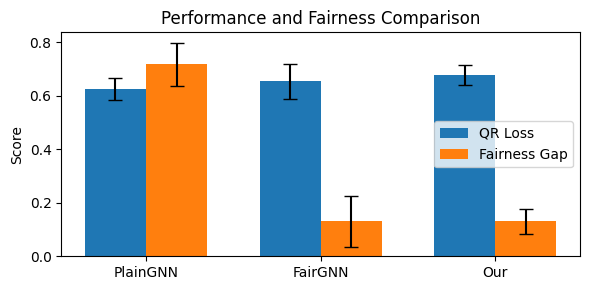

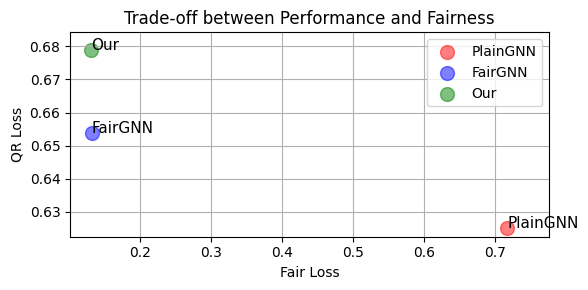

In [102]:
# 시각화
models = ['PlainGNN', 'FairGNN', 'Our']
colors = ['red', 'blue', 'green']

qr_means = all_results['QR Loss Mean']
qr_stds = all_results['QR Loss Std']
fair_means = all_results['Fairness Gap Mean']
fair_stds = all_results['Fairness Gap Std']
qr_gap = np.round(np.max(qr_means) - np.min(qr_means), 3)
fair_gap = np.round(np.max(fair_means) - np.min(fair_means), 3)

x = np.arange(len(models))
width = 0.35
fig, ax1 = plt.subplots(figsize=(6,3))
ax1.bar(x - width/2, qr_means, width, yerr=qr_stds, capsize=5, label='QR Loss')
ax1.bar(x + width/2, fair_means, width, yerr=fair_stds, capsize=5, label='Fairness Gap')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='best')
ax1.set_title('Performance and Fairness Comparison')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
for i in range(len(models)):
    plt.scatter(fair_means[i], qr_means[i], color=colors[i], label=models[i], s=100, alpha=0.5)
for i in range(len(models)):
    plt.text(fair_means[i], qr_means[i], models[i], fontsize=11)

plt.ylabel('QR Loss')
plt.xlabel('Fair Loss')
plt.ylim(top = np.max(qr_means) + qr_gap/10)
plt.xlim(right = np.max(fair_means) + fair_gap/10)
plt.title('Trade-off between Performance and Fairness')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 추가 실험

In [104]:
# lambda_fair Trade-off 실험
lambdas = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
results = []

for lambda_fair in lambdas:
    print(f"\n=== Lambda {lambda_fair} ===")
    fair_results, _ = multiple_runs_with_full_metrics(DistributionAwareFairGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair)

    fair_results['Lambda'] = lambda_fair
    results.append(fair_results)


=== Lambda 0.0 ===
----------------------------------------------------------------------------------------------------

 [DistributionAwareFairGNN] --- Run 1/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 7.6071
[Epoch 100] Loss: 0.8239
[Epoch 200] Loss: 0.8123
[Epoch 300] Loss: 0.7989
[Epoch 400] Loss: 0.7734
[Epoch 500] Loss: 0.7184

 [DistributionAwareFairGNN] --- Run 2/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 25.9505
[Epoch 100] Loss: 0.8263
[Epoch 200] Loss: 0.8060
[Epoch 300] Loss: 0.7888
[Epoch 400] Loss: 0.7265
[Epoch 500] Loss: 0.7776

 [DistributionAwareFairGNN] --- Run 3/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 10.9024
[Epoch 100] Loss: 0.8252
[Epoch 200] Loss: 0.8108
[Epoch 300] Loss: 0.7871
[Epoch 400] Loss: 0.7388
[Epoch 500] Loss: 0.

In [108]:
df_lambda = pd.DataFrame(results)
df_lambda.round(4)

,QR Loss Mean,QR Loss Std,MAE Mean,MAE Std,RMSE Mean,RMSE Std,R2 Mean,R2 Std,Fairness Gap Mean,Fairness Gap Std,Lambda
0,0.6398,0.0300,5.0347,1.0447,5.9431,1.0952,-2.2302,1.0297,0.7486,0.0783,0.00
1,0.6177,0.0369,4.8036,0.9577,5.6771,0.9710,-1.9341,0.9896,0.6464,0.0794,0.01
2,0.6471,0.1212,5.6536,1.4627,6.4156,1.4446,-2.8251,1.9108,0.4309,0.1394,0.05
3,0.5897,0.0279,4.5419,0.5585,5.3314,0.6264,-1.5488,0.5855,0.2008,0.1480,0.10
4,0.6132,0.0221,4.6082,0.6055,5.4219,0.6064,-1.6327,0.5944,0.0564,0.0295,0.50
5,0.6652,0.0372,5.2318,0.9125,6.0888,0.9047,-2.3515,0.9695,0.1166,0.0790,1.00
6,0.6584,0.0141,5.2408,0.3457,6.1462,0.3360,-2.3513,0.3651,0.1804,0.0267,5.00
7,0.6399,0.0165,4.9940,0.5115,5.8484,0.5442,-2.0516,0.5335,0.1825,0.0573,10.00


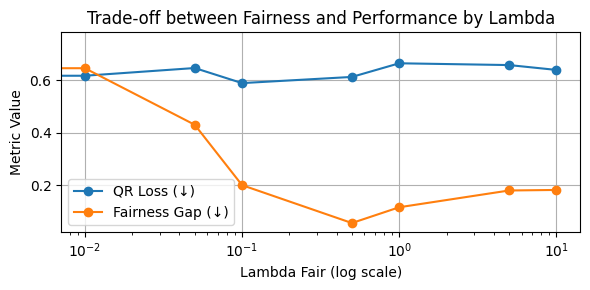

In [109]:
# 시각화
plt.figure(figsize=(6,3))
plt.plot(df_lambda['Lambda'], df_lambda['QR Loss Mean'], marker='o', label='QR Loss (↓)')
plt.plot(df_lambda['Lambda'], df_lambda['Fairness Gap Mean'], marker='o', label='Fairness Gap (↓)')
plt.xscale('log')  # λ는 보통 로그스케일로 표현
plt.xlabel('Lambda Fair (log scale)')
plt.ylabel('Metric Value')
plt.title('Trade-off between Fairness and Performance by Lambda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
# Ablation study
df_ablation = run_ablation_experiments(data, device, n_runs)


[Full] Run 1/5
[Epoch 1] Loss: 1.3637
[Epoch 100] Loss: 0.8525
[Epoch 200] Loss: 0.8478
[Epoch 300] Loss: 0.8096
[Epoch 400] Loss: 0.8182
[Epoch 500] Loss: 0.7868

[Full] Run 2/5
[Epoch 1] Loss: 13.8693
[Epoch 100] Loss: 0.8726
[Epoch 200] Loss: 0.8532
[Epoch 300] Loss: 0.8924
[Epoch 400] Loss: 0.8114
[Epoch 500] Loss: 0.7550

[Full] Run 3/5
[Epoch 1] Loss: 6.3494
[Epoch 100] Loss: 0.9329
[Epoch 200] Loss: 0.8957
[Epoch 300] Loss: 0.8845
[Epoch 400] Loss: 0.9099
[Epoch 500] Loss: 0.8529

[Full] Run 4/5
[Epoch 1] Loss: 8.2176
[Epoch 100] Loss: 1.2064
[Epoch 200] Loss: 0.8442
[Epoch 300] Loss: 0.8386
[Epoch 400] Loss: 0.8273
[Epoch 500] Loss: 0.7918

[Full] Run 5/5
[Epoch 1] Loss: 7.9730
[Epoch 100] Loss: 0.9571
[Epoch 200] Loss: 0.8536
[Epoch 300] Loss: 0.8129
[Epoch 400] Loss: 0.7705
[Epoch 500] Loss: 0.7592

[w/o Projection] Run 1/5
[Epoch 1] Loss: 16.1702
[Epoch 100] Loss: 0.9711
[Epoch 200] Loss: 0.8404
[Epoch 300] Loss: 0.8432
[Epoch 400] Loss: 0.8763
[Epoch 500] Loss: 0.8656

[w/

In [ ]:
# 실험 결과
df_ablation.round(4)

In [ ]:
# 시각화
x = np.arange(len(df_ablation))
width = 0.35
fig, ax1 = plt.subplots(figsize=(6,3))
ax1.bar(x - width/2, df_ablation['QR Loss Mean'], width, yerr=df_ablation['QR Loss Std'], label='QR Loss')
ax1.bar(x + width/2, df_ablation['Fairness Gap Mean'], width, yerr=df_ablation['Fairness Gap Std'], label='Fairness Gap')
ax1.set_ylabel('Metric Value')
ax1.set_title('Ablation Study: QR Loss vs Fairness Gap')
ax1.set_xticks(x)
ax1.set_xticklabels(df_ablation['Setting'])
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor

import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from dgl.nn.pytorch import GraphConv
import torch_sparse
from torch_sparse import SparseTensor, matmul

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

def get_sen(sens, idx_sens_train):
    sens_zeros = torch.zeros_like(sens)
    sens_1 = sens 
    sens_0 = (1 - sens) 
    
    sens_1[idx_sens_train] = sens_1[idx_sens_train] / len(sens_1[idx_sens_train])
    sens_0[idx_sens_train] = sens_0[idx_sens_train] / len(sens_0[idx_sens_train])

    sens_zeros[idx_sens_train] = sens_1[idx_sens_train] - sens_0[idx_sens_train]
    sen_mat = torch.unsqueeze(sens_zeros, dim=0)
    return sen_mat

def check_sen(edge_index, sen):
    nnz = edge_index.nnz()
    deg = torch.eye(edge_index.sizes()[0]).cuda()
    adj = edge_index.to_dense()
    lap = (sen.t() @ sen).to_dense()
    lap2 = deg - adj
    diff = torch.sum(torch.abs(lap2-lap)) / nnz
    assert diff < 0.000001, f'error: {diff} need to make sure L=B^TB'

class FMP(GraphConv):
    r"""Fair message passing layer
    """
    _cached_sen = Optional[SparseTensor]

    def __init__(self, 
                 in_feats: int,
                 out_feats: int,
                 K: int, 
                 lambda1: float = None,
                 lambda2: float = None,
                 L2: bool = True,
                 dropout: float = 0.,
                 cached: bool = False, 
                 **kwargs):

        super(FMP, self).__init__(in_feats, out_feats)
        self.K = K
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None  ## sensitive matrix
        self.propa = GraphConv(in_feats, in_feats, weight=False, bias=False, activation=None)

    def reset_parameters(self):
        self._cached_sen = None

    def forward(self, x: Tensor, 
                g, 
                idx_sens_train,
                edge_weight: OptTensor = None, 
                sens=None) -> Tensor:

        if self.K <= 0: return x

        cache = self._cached_sen
        if cache is None:
            sen_mat = get_sen(sens=sens, idx_sens_train=idx_sens_train)               ## compute sensitive matrix

            if self.cached:
                self._cached_sen = sen_mat
                self.init_z = torch.zeros((sen_mat.size()[0], x.size()[-1])).cuda()
        else:
            sen_mat = self._cached_sen # N,

        hh = x
        x = self.emp_forward(g, x=x, hh=hh, sen=sen_mat, K=self.K)
        return x

    def emp_forward(self, g, x, hh, K, sen):
        lambda1 = self.lambda1
        lambda2 = self.lambda2

        gamma = 1/(1+lambda2)
        beta = 1/(2*gamma)

        for _ in range(K):

            if lambda2 > 0:
                y = gamma * hh + (1-gamma) * self.propa(g, feat=x)
            else:
                y = gamma * hh + (1-gamma) * x # y = x - gamma * (x - hh)

            if lambda1 > 0:
                z = sen @ F.softmax(y, dim=1) / (gamma * sen @ sen.t())
                
                x_bar0 = sen.t() @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature

                correct = x_bar0 * x_bar1 

                coeff = torch.sum(x_bar0 * x_bar1, 1, keepdim=True)
                correct = correct - coeff * x_bar1

                x_bar = y - gamma * correct
                z_bar  = z + beta * (sen @ F.softmax(x_bar, dim=1))
                
                if self.L2:
                    z  = self.L2_projection(z_bar, lambda_=lambda1, beta=beta)
                else:
                    z  = self.L1_projection(z_bar, lambda_=lambda1)
                
                x_bar0 = sen.t() @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature
                
                correct = x_bar0 * x_bar1 
                coeff = torch.sum(x_bar0 * x_bar1, 1, keepdim=True)
                correct = correct - coeff * x_bar1
                x = y - gamma * correct
            else:
                x = y # z=0

            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    def L1_projection(self, x: Tensor, lambda_):
        return torch.clamp(x, min=-lambda_, max=lambda_)
    
    def L2_projection(self, x: Tensor, lambda_, beta):
        coeff = (2*lambda_) / (2*lambda_ + beta)
        return coeff * x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, lambda1={}, lambda2={}, L2={})'.format(
            self.__class__.__name__, self.K, self.lambda1, self.lambda2, self.L2)

class FairGNN(torch.nn.Module):
    def __init__(self, input_size, size, num_classes, num_layer, prop, **kwargs):
        super(FairGNN, self).__init__()

        self.hidden = nn.ModuleList()
        for _ in range(num_layer-2):
            self.hidden.append(nn.Linear(size, size))

        self.first = nn.Linear(input_size, size)
        self.last = nn.Linear(size, num_classes)

        
        self.prop = prop

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.prop.reset_parameters()

    def forward(self, features, g, sens, idx_sens_train):
        x = features
        
        out = F.relu(self.first(x))

        for layer in self.hidden:
            out = F.relu(layer(out))
        
        x = self.last(out)

        x = self.prop(x, sens=sens, g=g, idx_sens_train=idx_sens_train)
        return x

def get_model(args, data):

    Model = FairGNN

    prop =  FMP(in_feats=data.num_features,
                out_feats=data.num_features,
                K=args.num_layers, 
                lambda1=args.lambda1,
                lambda2=args.lambda2,
                L2=args.L2,
                cached=True)

    model = Model(input_size=data.num_features, 
                    size=args.num_hidden, 
                    num_classes=data.num_classes, 
                    num_layer=args.num_gnn_layer, 
                    prop=prop).cuda()

    return model